In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
import random
from collections import Counter
import matplotlib.pyplot as plt
import time

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NUM_CLASSES = 10

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LOCAL_EPOCHS = 5
NUM_OF_CLIENTS = 10
COMM_ROUND = 50
ALPHA = 0.5
FRAC = 0.1
RHO = 0.05  # SAM perturbation radius (from paper)

Using device: cuda


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        f1 = F.relu(self.bn_fc1(self.fc1(x)))
        f1 = self.dropout1(f1)
        f2 = F.relu(self.bn_fc2(self.fc2(f1)))
        f2 = self.dropout2(f2)
        logits = self.fc3(f2)
        return f2, logits  # features, logits


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

# ========================================
# 3. TEMPNET
# ========================================
class TempNet(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128, tau_min=0.05, tau_max=2.0):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tau_min = tau_min
        self.tau_max = tau_max

    def forward(self, x):
        h = F.relu(self.fc1(x))
        raw = self.fc2(h)
        tau = torch.sigmoid(raw)
        tau = tau * (self.tau_max - self.tau_min) + self.tau_min
        return tau.mean()

100%|██████████| 170M/170M [00:06<00:00, 27.6MB/s]


Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.16', '1:0.09', '2:0.00', '3:0.06', '4:0.21', '5:0.06', '6:0.10', '7:0.31', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.11', '1:0.07', '2:0.35', '3:0.12', '4:0.03', '5:0.17', '6:0.03', '7:0.00', '8:0.10', '9:0.02']
Client 6 class dist: ['0:0.01', '1:0.06', '2:0.11', '3:0.01', '4:0.00', '5:0.06', '6:0.01', '7:0.53', '8:0.00', '9:0.22']
Client 7 class dist: ['0:0.12', '1:0.02', '2:0.03', '3:0.18', '4:0.06', '5:0.05', '6:0.11', '7:0.13', '8:0.01', '9:0.2

In [3]:
class BaseClient:
    """Base class for federated learning clients"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9):
        self.client_id = client_id
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.learning_rate = learning_rate
        self.local_epochs = local_epochs
        self.momentum = momentum
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_samples = 0

    def train(self):
        raise NotImplementedError

    def set_parameters(self, model_state_dict):
        """Load model parameters from server"""
        self.model.load_state_dict(model_state_dict)

    def get_parameters(self):
        """Get model parameters"""
        return self.model.state_dict()

    def get_train_samples(self):
        """Get number of training samples"""
        try:
            return len(self.train_loader.dataset)
        except:
            return len(self.train_loader) * BATCH_SIZE


class BaseServer:
    """Base class for federated learning server"""

    def __init__(self, global_model, test_loader, num_clients, learning_rate=0.01,
                 lr_decay=0.998, device='cuda'):
        self.global_model = copy.deepcopy(global_model)
        self.test_loader = test_loader
        self.num_clients = num_clients
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.device = device
        self.clients = []
        self.loss_fn = nn.CrossEntropyLoss()

    def send_models(self, clients):
        """Send global model to clients"""
        model_state = self.global_model.state_dict()
        for client in clients:
            client.set_parameters(model_state)

    def receive_models(self, clients):
        """Receive trained models from clients and aggregate"""
        self.client_models = [client.get_parameters() for client in clients]
        self.client_samples = [client.get_train_samples() for client in clients]

    def aggregate_parameters(self):
        """Aggregate client models using weighted averaging

        IMPORTANT: This method handles mixed dtypes in model state dict.
        Batch normalization layers have both float parameters AND integer buffers
        (like num_batches_tracked). We must convert to float for weighted averaging,
        then convert back to original dtype to avoid RuntimeError.
        """
        total_samples = sum(self.client_samples)
        avg_state = {}

        # Get first model as reference
        for key in self.client_models[0].keys():
            # Get original dtype (may be float32, float64, or int64)
            first_tensor = self.client_models[0][key]
            original_dtype = first_tensor.dtype

            # Initialize accumulator with zeros, using float32 for safe averaging
            avg_state[key] = torch.zeros_like(first_tensor, dtype=torch.float32)

            # Weighted average: convert each tensor to float before summing
            for model_state, num_samples in zip(self.client_models, self.client_samples):
                weight = num_samples / total_samples
                # .float() converts int64 buffers to float32, allows weighted addition
                avg_state[key] += weight * model_state[key].float()

            # Convert result back to original dtype
            # Float params stay float, int buffers become int again
            avg_state[key] = avg_state[key].to(original_dtype)

        self.global_model.load_state_dict(avg_state)

    def evaluate(self):
        """Evaluate global model on test data"""
        self.global_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in self.test_loader:
                X, y = X.to(self.device), y.to(self.device)
                output = self.model_forward(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                _, predicted = torch.max(logits, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy = correct / total
        return accuracy

    def model_forward(self, X):
        """Forward pass through model"""
        return self.global_model(X)


# ========================================
# FEDAVG IMPLEMENTATION
# ========================================

class ClientFedAvg(BaseClient):
    """Standard FedAvg client using SGD"""

    def train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                optimizer.step()


class FedAvgServer(BaseServer):
    """Standard FedAvg server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvg(i, copy.deepcopy(global_model), train_loader,
                                 val_loader, device, learning_rate=learning_rate,
                                 local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        """Execute one communication round"""
        self.send_models(self.clients)

        for client in self.clients:
            client.train()

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        self.learning_rate *= self.lr_decay

        return acc


# ========================================
# FEDAVG + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedAvgTemp(BaseClient):
    """FedAvg + Temperature: Standard SGD with learned temperature scaling"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(),
                                       lr=learning_rate)

    def train(self):
        self.model.train()
        self.tempnet.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output

                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()

                optimizer.step()
                self.temp_optimizer.step()

    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedAvgTempServer(BaseServer):
    """FedAvg + Temperature Server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.tau_history = []

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvgTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)

        self.learning_rate *= self.lr_decay

        return acc, avg_tau

# ========================================
# SAM OPTIMIZER (Sharpness Aware Minimization)
# ========================================

class SAMOptimizer(optim.Optimizer):
    """SAM optimizer - Sharpness Aware Minimization"""

    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive)
        super().__init__(params, defaults)

        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
            group["adaptive"] = adaptive

    @torch.no_grad()
    def first_step(self):
        """Perturbation step: climb to local maximum"""
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # Move to perturbed point θ + ε
                self.state[p]["e_w"] = e_w

    @torch.no_grad()
    def second_step(self):
        """Restore to original point (do this BEFORE applying gradients)"""
        for group in self.param_groups:
            for p in group["params"]:
                if "e_w" in self.state[p]:
                    p.sub_(self.state[p]["e_w"])  # Return to original θ
                    self.state[p]["e_w"] = 0

    def _grad_norm(self):
        """Compute gradient norm across all parameters"""
        norm = torch.norm(torch.stack([
            ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2)
            for group in self.param_groups for p in group["params"]
            if p.grad is not None
        ]), p=2)
        return norm


# ========================================
# FEDSAM IMPLEMENTATION
# ========================================

class ClientFedSAM(BaseClient):
    """FedSAM client using SAM optimizer"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05,
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0

    def train(self):
        self.model.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # First forward-backward: compute gradient at θ
                base_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()

                # SAM first step: ascent to θ + ε
                sam_optimizer.first_step()

                # Second forward-backward: compute gradient at perturbed point θ + ε
                base_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    _, logits_pert = output_pert
                else:
                    logits_pert = output_pert
                loss_pert = self.loss_fn(logits_pert, y)
                loss_pert.backward()

                # SAM second step: restore to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()

                # Apply gradient from perturbed point to original θ
                base_optimizer.step()


class FedSAMServer(BaseServer):
    """FedSAM server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAM(i, copy.deepcopy(global_model), train_loader,
                                 val_loader, device, learning_rate=learning_rate,
                                 local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        for client in self.clients:
            client.train()

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        self.learning_rate *= self.lr_decay

        return acc


# ========================================
# FEDSAM + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedSAMTemp(BaseClient):
    """FedSAM + Temperature: SAM with learned temperature scaling"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05,
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(),
                                       lr=learning_rate)

    def train(self):
        self.model.train()
        self.tempnet.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # First forward-backward: compute gradient at θ with temperature
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output

                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()

                # SAM first step: ascent to θ + ε (model only)
                sam_optimizer.first_step()

                # Second forward-backward: at perturbed point θ + ε
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    features_pert, logits_pert = output_pert
                else:
                    features_pert = None
                    logits_pert = output_pert

                tau_pert = self.tempnet(features_pert.detach()) if features_pert is not None else torch.tensor(1.0, device=self.device)
                scaled_logits_pert = logits_pert / tau_pert
                loss_pert = self.loss_fn(scaled_logits_pert, y)
                loss_pert.backward()

                # SAM second step: restore model to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()

                # Apply gradients: model gets gradient from perturbed point, tempnet standard update
                base_optimizer.step()
                self.temp_optimizer.step()

    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedSAMTempServer(BaseServer):
    """FedSAM + Temperature Server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = []

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAMTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)

        self.learning_rate *= self.lr_decay

        return acc, avg_tau

In [4]:
def run_fedsam():
    """Run FedSAM training"""
    print("\n" + "="*60)
    print("STARTING FedSAM TRAINING")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)

        print(f"[FedSAM] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")

    return test_accs, server.global_model

def run_fedsam_temp():
    """Run FedSAM + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedSAM + TEMP TRAINING")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)

        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")

    return test_accs, tau_history, server.global_model

Training FedSAM...

STARTING FedSAM TRAINING
[FedSAM] R1/50 Test Acc: 0.1892 | Time: 18.53s
[FedSAM] R2/50 Test Acc: 0.3101 | Time: 15.04s
[FedSAM] R3/50 Test Acc: 0.3603 | Time: 15.10s
[FedSAM] R4/50 Test Acc: 0.3898 | Time: 15.43s
[FedSAM] R5/50 Test Acc: 0.4181 | Time: 15.58s
[FedSAM] R6/50 Test Acc: 0.4406 | Time: 15.47s
[FedSAM] R7/50 Test Acc: 0.4544 | Time: 15.59s
[FedSAM] R8/50 Test Acc: 0.4626 | Time: 16.17s
[FedSAM] R9/50 Test Acc: 0.4824 | Time: 15.54s
[FedSAM] R10/50 Test Acc: 0.5013 | Time: 15.54s
[FedSAM] R11/50 Test Acc: 0.4958 | Time: 16.21s
[FedSAM] R12/50 Test Acc: 0.5139 | Time: 15.64s
[FedSAM] R13/50 Test Acc: 0.5178 | Time: 15.74s
[FedSAM] R14/50 Test Acc: 0.5337 | Time: 16.04s
[FedSAM] R15/50 Test Acc: 0.5309 | Time: 15.63s
[FedSAM] R16/50 Test Acc: 0.5325 | Time: 15.58s
[FedSAM] R17/50 Test Acc: 0.5438 | Time: 15.92s
[FedSAM] R18/50 Test Acc: 0.5411 | Time: 15.86s
[FedSAM] R19/50 Test Acc: 0.5493 | Time: 15.58s
[FedSAM] R20/50 Test Acc: 0.5466 | Time: 15.63s
[Fed

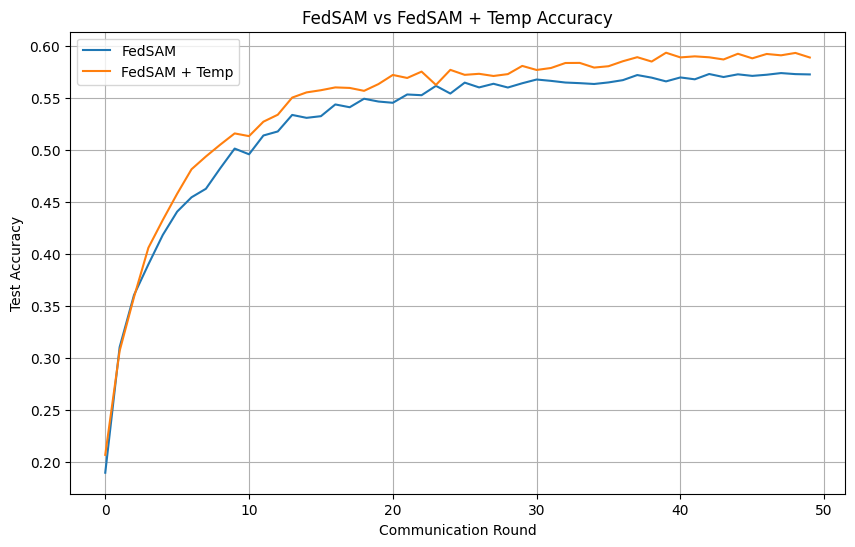

In [5]:
# Run Training
print("Training FedSAM...")
fedsam_accs, fedsam_model = run_fedsam()

print("\nTraining FedSAM + Temp...")
fedsam_temp_accs, fedsam_temp_tau, fedsam_temp_model = run_fedsam_temp()

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(fedsam_accs, label='FedSAM')
plt.plot(fedsam_temp_accs, label='FedSAM + Temp')
plt.xlabel('Communication Round')
plt.ylabel('Test Accuracy')
plt.title('FedSAM vs FedSAM + Temp Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# ========================================
# TEMP NET LEARNING ANALYSIS
# ========================================

# Redefine Server to capture full temperature distribution and model divergence
class FedSAMTempServerDetailed(BaseServer):
    """FedSAM + Temperature Server with detailed logging"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = [] # Will store list of lists
        self.model_div_history = [] # Store list of lists of model divergences

        # Initialize clients
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAMTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        # Keep reference to global weights before update
        global_weights = copy.deepcopy(self.global_model.state_dict())

        self.send_models(self.clients)

        local_taus = []
        local_divs = []

        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

            # Calculate divergence: || w_client - w_global ||_2
            client_weights = client.get_parameters()
            div = 0.0
            for key in global_weights:
                # Skip non-parameter buffers if necessary
                if 'num_batches_tracked' in key: continue

                # Calculate squared difference
                diff = (client_weights[key].float() - global_weights[key].float()).pow(2).sum().item()
                div += diff

            local_divs.append(np.sqrt(div))

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()

        # Store history
        self.tau_history.append(local_taus)
        self.model_div_history.append(local_divs)

        self.learning_rate *= self.lr_decay

        return acc, local_taus, local_divs

def run_fedsam_temp_detailed():
    """Run FedSAM + Temperature training with detailed logging"""
    print("\n" + "="*60)
    print("STARTING FedSAM + TEMP TRAINING (Detailed Analysis)")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMTempServerDetailed(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    tau_history_detailed = []
    div_history_detailed = []

    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, local_taus, local_divs = server.train_round()
        test_accs.append(acc)
        tau_history_detailed.append(local_taus)
        div_history_detailed.append(local_divs)

        avg_tau = sum(local_taus)/len(local_taus)
        std_tau = np.std(local_taus)
        avg_div = sum(local_divs)/len(local_divs)

        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Acc: {acc:.4f} | τ: {avg_tau:.3f}±{std_tau:.3f} | Div: {avg_div:.3f} | Time: {time.time()-round_start:.1f}s")

    return test_accs, tau_history_detailed, div_history_detailed, server.global_model

# Run the detailed training
fedsam_temp_accs_new, fedsam_temp_tau_history, fedsam_temp_div_history, fedsam_temp_model_new = run_fedsam_temp_detailed()

# Analysis Plots
tau_history_array = np.array(fedsam_temp_tau_history) # Shape: [Rounds, Clients]
div_history_array = np.array(fedsam_temp_div_history) # Shape: [Rounds, Clients]

rounds = np.arange(1, COMM_ROUND + 1)
mean_taus = np.mean(tau_history_array, axis=1)
std_taus = np.std(tau_history_array, axis=1)
min_taus = np.min(tau_history_array, axis=1)
max_taus = np.max(tau_history_array, axis=1)

mean_divs = np.mean(div_history_array, axis=1)
std_divs = np.std(div_history_array, axis=1)

plt.figure(figsize=(18, 10))

# 1. Evolution of Temperature (Mean +/- Std)
plt.subplot(2, 3, 1)
plt.plot(rounds, mean_taus, label='Mean Temperature', color='red')
plt.fill_between(rounds, mean_taus - std_taus, mean_taus + std_taus, color='red', alpha=0.2, label='Std Dev')
plt.xlabel('Communication Round')
plt.ylabel('Temperature (τ)')
plt.title('Evolution of Temperature (Mean ± Std)')
plt.legend()
plt.grid(True)

# 2. Evolution of Temperature (Min/Max range)
plt.subplot(2, 3, 2)
plt.plot(rounds, mean_taus, label='Mean', color='red')
plt.plot(rounds, min_taus, label='Min Client τ', linestyle='--', color='orange')
plt.plot(rounds, max_taus, label='Max Client τ', linestyle='--', color='purple')
plt.xlabel('Communication Round')
plt.ylabel('Temperature (τ)')
plt.title('Temperature Range across Clients')
plt.legend()
plt.grid(True)

# 3. Temperature Divergence (Std Dev over time)
plt.subplot(2, 3, 3)
plt.plot(rounds, std_taus, color='green')
plt.xlabel('Communication Round')
plt.ylabel('Standard Deviation of τ')
plt.title('Temperature Divergence (Client Disagreement)')
plt.grid(True)

# 4. Final Distribution
plt.subplot(2, 3, 4)
plt.hist(tau_history_array[-1], bins=10, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Temperature (τ)')
plt.ylabel('Count')
plt.title(f'Distribution of Client Temperatures (Round {COMM_ROUND})')
plt.grid(True)

# 5. Model Parameter Divergence
plt.subplot(2, 3, 5)
plt.plot(rounds, mean_divs, label='Mean Divergence', color='blue')
plt.fill_between(rounds, mean_divs - std_divs, mean_divs + std_divs, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Communication Round')
plt.ylabel('L2 Distance from Global Model')
plt.title('Model Parameter Divergence (Client Drift)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


STARTING FedSAM + TEMP TRAINING (Detailed Analysis)
[FedSAM+Temp] R1/50 Acc: 0.1810 | τ: 0.886±0.090 | Div: 48.572 | Time: 16.9s
[FedSAM+Temp] R2/50 Acc: 0.2966 | τ: 0.754±0.091 | Div: 4.182 | Time: 16.3s
[FedSAM+Temp] R3/50 Acc: 0.3575 | τ: 0.668±0.065 | Div: 4.098 | Time: 15.9s
[FedSAM+Temp] R4/50 Acc: 0.3897 | τ: 0.622±0.042 | Div: 4.049 | Time: 15.9s
[FedSAM+Temp] R5/50 Acc: 0.4462 | τ: 0.583±0.038 | Div: 3.926 | Time: 16.1s
[FedSAM+Temp] R6/50 Acc: 0.4560 | τ: 0.549±0.029 | Div: 3.939 | Time: 15.9s
[FedSAM+Temp] R7/50 Acc: 0.4865 | τ: 0.518±0.042 | Div: 3.882 | Time: 16.0s
[FedSAM+Temp] R8/50 Acc: 0.4939 | τ: 0.515±0.044 | Div: 3.822 | Time: 16.1s
[FedSAM+Temp] R9/50 Acc: 0.5064 | τ: 0.507±0.046 | Div: 3.780 | Time: 15.8s
[FedSAM+Temp] R10/50 Acc: 0.5222 | τ: 0.499±0.036 | Div: 3.676 | Time: 15.8s


KeyboardInterrupt: 


STARTING FedSAM + TEMP TRAINING (Detailed Analysis)
[FedSAM+Temp] R1/50 Acc: 0.1833 | τ: 0.879±0.071 | TempNet Div: 0.114 | Time: 17.9s
[FedSAM+Temp] R2/50 Acc: 0.3139 | τ: 0.727±0.064 | TempNet Div: 0.214 | Time: 16.0s
[FedSAM+Temp] R3/50 Acc: 0.3660 | τ: 0.646±0.052 | TempNet Div: 0.269 | Time: 16.1s
[FedSAM+Temp] R4/50 Acc: 0.4064 | τ: 0.599±0.035 | TempNet Div: 0.298 | Time: 15.8s
[FedSAM+Temp] R5/50 Acc: 0.4320 | τ: 0.567±0.033 | TempNet Div: 0.319 | Time: 15.7s
[FedSAM+Temp] R6/50 Acc: 0.4725 | τ: 0.536±0.034 | TempNet Div: 0.342 | Time: 16.0s
[FedSAM+Temp] R7/50 Acc: 0.4791 | τ: 0.526±0.037 | TempNet Div: 0.352 | Time: 16.7s
[FedSAM+Temp] R8/50 Acc: 0.4857 | τ: 0.504±0.026 | TempNet Div: 0.362 | Time: 15.8s
[FedSAM+Temp] R9/50 Acc: 0.5116 | τ: 0.492±0.035 | TempNet Div: 0.371 | Time: 16.1s
[FedSAM+Temp] R10/50 Acc: 0.5159 | τ: 0.484±0.038 | TempNet Div: 0.380 | Time: 15.9s
[FedSAM+Temp] R11/50 Acc: 0.5261 | τ: 0.479±0.031 | TempNet Div: 0.383 | Time: 15.8s
[FedSAM+Temp] R12/50 

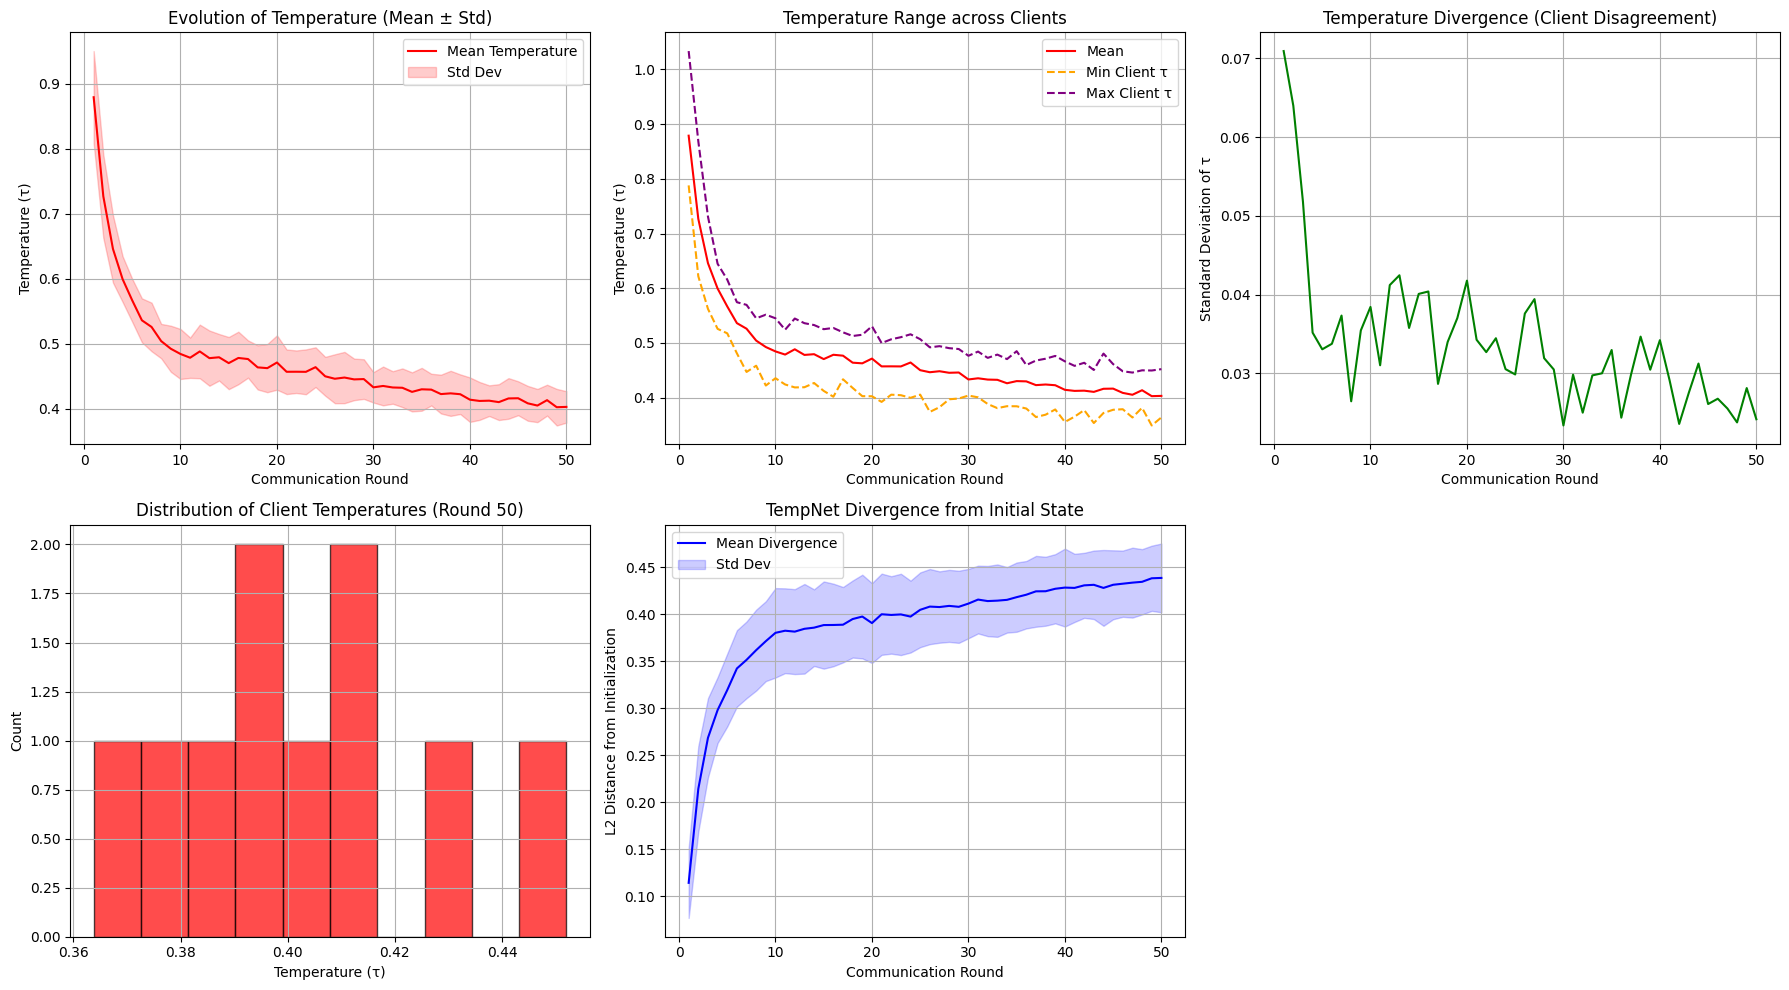

In [14]:
# ========================================
# TEMP NET LEARNING ANALYSIS
# ========================================

# Redefine Server to capture full temperature distribution and TempNet divergence
class FedSAMTempServerDetailed(BaseServer):
    """FedSAM + Temperature Server with detailed logging"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = [] # Will store list of lists
        self.tempnet_div_history = [] # Store list of lists of TempNet divergences

        # Initialize clients
        self.initial_tempnets = []
        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAMTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)
            # Store initial TempNet state for divergence calculation
            self.initial_tempnets.append(copy.deepcopy(client.tempnet.state_dict()))

    def train_round(self):
        self.send_models(self.clients)

        local_taus = []
        local_divs = []

        for i, client in enumerate(self.clients):
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

            # Calculate TempNet divergence: || tempnet_current - tempnet_initial ||_2
            current_temp_weights = client.tempnet.state_dict()
            initial_temp_weights = self.initial_tempnets[i]

            div = 0.0
            for key in current_temp_weights:
                # Calculate squared difference
                diff = (current_temp_weights[key].float() - initial_temp_weights[key].float()).pow(2).sum().item()
                div += diff

            local_divs.append(np.sqrt(div))

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()

        # Store history
        self.tau_history.append(local_taus)
        self.tempnet_div_history.append(local_divs)

        self.learning_rate *= self.lr_decay

        return acc, local_taus, local_divs

def run_fedsam_temp_detailed():
    """Run FedSAM + Temperature training with detailed logging"""
    print("\n" + "="*60)
    print("STARTING FedSAM + TEMP TRAINING (Detailed Analysis)")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMTempServerDetailed(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    tau_history_detailed = []
    div_history_detailed = []

    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, local_taus, local_divs = server.train_round()
        test_accs.append(acc)
        tau_history_detailed.append(local_taus)
        div_history_detailed.append(local_divs)

        avg_tau = sum(local_taus)/len(local_taus)
        std_tau = np.std(local_taus)
        avg_div = sum(local_divs)/len(local_divs)

        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Acc: {acc:.4f} | τ: {avg_tau:.3f}±{std_tau:.3f} | TempNet Div: {avg_div:.3f} | Time: {time.time()-round_start:.1f}s")

    return test_accs, tau_history_detailed, div_history_detailed, server.global_model

# Run the detailed training
fedsam_temp_accs_new, fedsam_temp_tau_history, fedsam_temp_div_history, fedsam_temp_model_new = run_fedsam_temp_detailed()

# Analysis Plots
tau_history_array = np.array(fedsam_temp_tau_history) # Shape: [Rounds, Clients]
div_history_array = np.array(fedsam_temp_div_history) # Shape: [Rounds, Clients]

rounds = np.arange(1, COMM_ROUND + 1)
mean_taus = np.mean(tau_history_array, axis=1)
std_taus = np.std(tau_history_array, axis=1)
min_taus = np.min(tau_history_array, axis=1)
max_taus = np.max(tau_history_array, axis=1)

mean_divs = np.mean(div_history_array, axis=1)
std_divs = np.std(div_history_array, axis=1)

plt.figure(figsize=(18, 10))

# 1. Evolution of Temperature (Mean +/- Std)
plt.subplot(2, 3, 1)
plt.plot(rounds, mean_taus, label='Mean Temperature', color='red')
plt.fill_between(rounds, mean_taus - std_taus, mean_taus + std_taus, color='red', alpha=0.2, label='Std Dev')
plt.xlabel('Communication Round')
plt.ylabel('Temperature (τ)')
plt.title('Evolution of Temperature (Mean ± Std)')
plt.legend()
plt.grid(True)

# 2. Evolution of Temperature (Min/Max range)
plt.subplot(2, 3, 2)
plt.plot(rounds, mean_taus, label='Mean', color='red')
plt.plot(rounds, min_taus, label='Min Client τ', linestyle='--', color='orange')
plt.plot(rounds, max_taus, label='Max Client τ', linestyle='--', color='purple')
plt.xlabel('Communication Round')
plt.ylabel('Temperature (τ)')
plt.title('Temperature Range across Clients')
plt.legend()
plt.grid(True)

# 3. Temperature Divergence (Std Dev over time)
plt.subplot(2, 3, 3)
plt.plot(rounds, std_taus, color='green')
plt.xlabel('Communication Round')
plt.ylabel('Standard Deviation of τ')
plt.title('Temperature Divergence (Client Disagreement)')
plt.grid(True)

# 4. Final Distribution
plt.subplot(2, 3, 4)
plt.hist(tau_history_array[-1], bins=10, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Temperature (τ)')
plt.ylabel('Count')
plt.title(f'Distribution of Client Temperatures (Round {COMM_ROUND})')
plt.grid(True)

# 5. TempNet Parameter Divergence
plt.subplot(2, 3, 5)
plt.plot(rounds, mean_divs, label='Mean Divergence', color='blue')
plt.fill_between(rounds, mean_divs - std_divs, mean_divs + std_divs, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Communication Round')
plt.ylabel('L2 Distance from Initialization')
plt.title('TempNet Divergence from Initial State')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()